## 9.4 Q Learning for Cart-Pole


In [28]:
import numpy as np
import tensorflow as tf
import gym 
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
import time

In [29]:
class FeatureTransformer:
    def __init__(self,env):
        obs_examples = np.random.random((20000,4))
        print(obs_examples)
        scaler = StandardScaler()
        scaler.fit(obs_examples)
        
        # used to convert a state to a featurized representation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
            ("cart_position", RBFSampler(gamma=0.02, n_components=500)),
            ("cart_velocity", RBFSampler(gamma=1.0, n_components=500)),
            ("pole_angle", RBFSampler(gamma=0.5, n_components=500)),
            ("pole_velocity", RBFSampler(gamma=0.1, n_components=500))
        ])
        feature_examples = featurizer.fit_transform(scaler.transform(obs_examples))
        print(feature_examples.shape)
        
        self.dimension = feature_examples.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer
    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

In [30]:
class NeuralNetwork:
    def __init__(self, D):
        eta = 0.1
        self.W = tf.Variable(tf.random_normal(shape=(D,1)), name = 'w')
        self.X = tf.placeholder(tf.float32, shape=(None,D), name = 'X')
        self.Y = tf.placeholder(tf.float32, shape=(None,), name = 'Y')
        # make prediction and cost
        Y_hat = tf.reshape(tf.matmul(self.X, self.W),[-1])
        err = self.Y - Y_hat
        cost = tf.reduce_sum(tf.pow(err,2))
        
        # ops we want to call later
        self.train_op = tf.train.GradientDescentOptimizer(eta).minimize(cost)
        self.predict_op = Y_hat
        
        # start the session and initialize params
        init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(init)
        
    def train(self,X,Y):
        self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})
        
    def predict(self,X):
        return self.session.run(self.predict_op, feed_dict={self.X:X})

In [31]:
class Agent:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.agent = []
        self.feature_transformer = feature_transformer
        for i in range(env.action_space.n):
            model = NeuralNetwork(feature_transformer.dimension)
            self.agent.append(model)
    def predict(self,s):
        X = self.feature_transformer.transform([s])
        return np.array([m.predict(X)[0] for m in self.agent])
    def update(self, s, a, G):
        X = self.feature_transformer.transform([s])
        self.agent[a].train(X,[G])
    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [32]:
def play_one(env, model, eps, gamma, render = False):
    obs = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 2000:
        action = model.sample_action(obs,eps)
        prev_obs = obs
        obs, reward, done, info = env.step(action)
        if render:
            env.render() # can comment it to speed up
            time.sleep(0.2)
    
        if done:
            reward = -400
    
        # update the model
        next = model.predict(obs)
        assert(len(next.shape) == 1)
        G = reward + gamma*np.max(next)
        model.update(prev_obs, action, G)
        
        if reward == 1:
            totalreward += reward
        iters += 1
    return totalreward

[[0.05388231 0.81998153 0.99023772 0.36079256]
 [0.17621995 0.55423536 0.46080491 0.84550699]
 [0.01535213 0.19205934 0.62150365 0.89380494]
 ...
 [0.02218222 0.08083529 0.94189334 0.11511878]
 [0.81018605 0.70589996 0.32810758 0.35316399]
 [0.47229638 0.54172862 0.14913857 0.66063867]]
(20000, 2000)
episode: 0, total reward: 16.0 eps: 1.0 avg reward (last 100): 16.0
episode: 100, total reward: 199.0 eps: 0.09950371902099892 avg reward (last 100): 124.08910891089108
episode: 200, total reward: 199.0 eps: 0.07053456158585983 avg reward (last 100): 150.47524752475246
episode: 300, total reward: 199.0 eps: 0.0576390417704235 avg reward (last 100): 169.12871287128712
episode: 400, total reward: 140.0 eps: 0.04993761694389223 avg reward (last 100): 177.84158415841586
episode: 500, total reward: 199.0 eps: 0.04467670516087703 avg reward (last 100): 183.77227722772278
episode: 600, total reward: 177.0 eps: 0.04079085082240021 avg reward (last 100): 186.32673267326732
episode: 700, total rewar

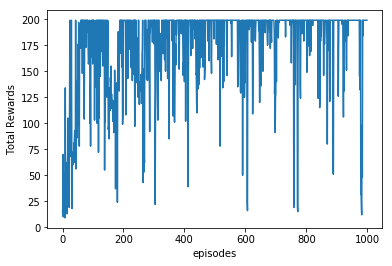

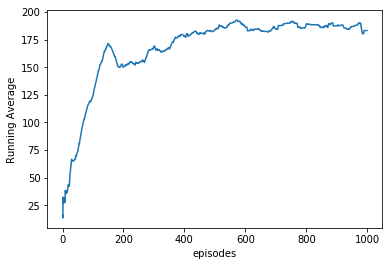

In [33]:
# main function
env_name = 'CartPole-v0'
env = gym.make(env_name)
ft = FeatureTransformer(env)
agent = Agent(env, ft)
gamma = 0.97

N = 1000
totalrewards = np.empty(N)
running_avg = np.empty(N)
for n in range(N):
    eps = 1.0 / np.sqrt(n+1)
    totalreward = play_one(env, agent, eps, gamma)
    totalrewards[n] = totalreward
    running_avg[n] = totalrewards[max(0, n-100):(n+1)].mean()
    if n % 100 == 0:
        print("episode: {0}, total reward: {1} eps: {2} avg reward (last 100): {3}".format(n,totalreward,eps,running_avg[n]),)
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.xlabel('episodes')
plt.ylabel('Total Rewards')
plt.show()

plt.plot(running_avg)
plt.xlabel('episodes')
plt.ylabel('Running Average')
plt.show()
plt.close()

In [34]:
play_one(env, agent, 0, gamma, render = True)

199.0

In [35]:
env.close()